Exploring Airbnb Data For Vancouver

Data Source: http://insideairbnb.com/get-the-data

Questions:

- #1: Does higher price mean higher rating? What if we bin listings according to price: Highest, High, Medium, Low, Lowest. And then review the correlations to ratings in each group?
- #2: What if bin listings according to date? What are the price trends through the seasons?
- What if bin listing according to neighborhood. Are there any trends in each neighborhood? Proportion of superhosts in each neighborhood?
- Aside from review what characteristics can be helpful in predicting a hosts rating?
- Can those same factors be used to classify whether a host is a superhost?

In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [49]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',500)

Load Data

In [50]:
calendar_dfs = []
listings_dfs = []
reviews_dfs = []

for subdir, dirs, files in  os.walk("./vancouver_data/"):
    for file in files:
        pth = os.path.join(subdir,file)
        if "calendar" in file:
            c_data = pd.read_csv(pth,compression='gzip')
            calendar_dfs.append(c_data)
        elif "listings" in file:
            l_data = pd.read_csv(pth)
            listings_dfs.append(l_data)
        elif "reviews" in file:
            r_data = pd.read_csv(pth)
            reviews_dfs.append(r_data)

calendar_df = pd.concat(calendar_dfs,ignore_index=True)
listings_df = pd.concat(listings_dfs,ignore_index=True)
reviews_df = pd.concat(reviews_dfs,ignore_index=True)

Preview Data

In [51]:
def explore_data(df):
    print(">>> New DataFrame <<< \n")
    print("DataFrame preview: \n",df.head())
    print("*"*20)
    print("Shape: \n", df.shape)
    print("*"*20)
    print("Statistics: \n",df.describe())
    print("*"*20)
    print("Data types: \n",df.dtypes)
    print("*"*20)
    print("Columns: \n",df.columns)
    print("*"*20)
    print("Index: \n",df.index)
    print("*"*20)
    print("Missing Values: \n",df.isna().sum())

In [52]:
# df_list = [calendar_df,listings_df,reviews_df]
# for frame in df_list:
#     explore_data(frame)

Prepare Data For Analysis

In [53]:
cal_df = calendar_df.copy()
lst_df = listings_df.copy()
rev_df = reviews_df.copy()


Calendar DataFrame

- Duplicate listing_id as a listing may be available on various dates.
- The price of a listing_id may differ depending on date.

In [54]:
cal_df.dtypes

listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object

In [55]:
cal_df.isna().sum()

listing_id           0
date                 0
available            0
price             1119
adjusted_price    1119
minimum_nights       6
maximum_nights       6
dtype: int64

In [56]:
cal_df.dropna(inplace=True)

In [57]:
cal_df.drop(labels=['adjusted_price'],axis=1,inplace=True)

In [58]:
cal_df['date'] = pd.to_datetime(calendar_df['date'])

In [59]:
cal_df['price'] = cal_df['price'].str.slice(start=1)
cal_df['price'] = cal_df['price'].replace(',','',regex=True)
cal_df['price'] = pd.to_numeric(cal_df['price'], errors='coerce')

In [60]:
cal_df.shape

(9014736, 6)

In [61]:
cal_df['available'].value_counts()

available
f    5520817
t    3493919
Name: count, dtype: int64

In [62]:
cal_df = cal_df[cal_df['available'] == 't']

In [63]:
cal_df.shape

(3493919, 6)

In [64]:
cal_df.head()

,listing_id,date,available,price,minimum_nights,maximum_nights
1,13358,2022-12-12,t,150.0,3.0,90.0
2,13358,2022-12-13,t,150.0,3.0,90.0
3,13358,2022-12-14,t,150.0,3.0,90.0
4,13358,2022-12-15,t,150.0,3.0,90.0
5,13358,2022-12-16,t,150.0,3.0,90.0


#1: Does higher price mean higher rating? What if we bin listings according to price: Highest, High, Medium, Low, Lowest. And then review the correlations to ratings in each group?

In [65]:
calendar = cal_df.drop(['available','date',\
                        'minimum_nights','maximum_nights'],axis=1)
calendar.head()

,listing_id,price
1,13358,150.0
2,13358,150.0
3,13358,150.0
4,13358,150.0
5,13358,150.0


In [66]:
calendar['price_category'] = pd.qcut(calendar['price'],q=5,\
                        labels=['Lowest','Low','Medium','High','Highest']) 

In [67]:
calendar.head()

,listing_id,price,price_category
1,13358,150.0,Low
2,13358,150.0,Low
3,13358,150.0,Low
4,13358,150.0,Low
5,13358,150.0,Low


In [68]:
ratings = lst_df[['id','review_scores_rating']].dropna(axis=0)

In [69]:
calendar_join_ratings = pd.merge(left=calendar,\
                                right=ratings,\
                                left_on="listing_id",\
                                right_on="id")

In [70]:
calendar_join_ratings.head()

,listing_id,price,price_category,id,review_scores_rating
0,13358,150.0,Low,13358,4.67
1,13358,150.0,Low,13358,4.68
2,13358,150.0,Low,13358,4.68
3,13358,150.0,Low,13358,4.68
4,13358,150.0,Low,13358,4.67


In [71]:
joined = calendar_join_ratings.drop(['listing_id','id'],axis=1)
joined.head()

,price,price_category,review_scores_rating
0,150.0,Low,4.67
1,150.0,Low,4.68
2,150.0,Low,4.68
3,150.0,Low,4.68
4,150.0,Low,4.67


In [72]:
price_category_grouped = joined.groupby(['price_category'],as_index=False)

In [73]:
for name,grp in price_category_grouped:
    print(name)
    print(grp[['price','review_scores_rating']].corr())
    print("*"*20)

('Lowest',)
                         price  review_scores_rating
price                 1.000000              0.150582
review_scores_rating  0.150582              1.000000
********************
('Low',)
                         price  review_scores_rating
price                 1.000000             -0.041802
review_scores_rating -0.041802              1.000000
********************
('Medium',)
                         price  review_scores_rating
price                 1.000000              0.047232
review_scores_rating  0.047232              1.000000
********************
('High',)
                         price  review_scores_rating
price                 1.000000              0.032858
review_scores_rating  0.032858              1.000000
********************
('Highest',)
                        price  review_scores_rating
price                 1.00000              -0.03349
review_scores_rating -0.03349               1.00000
********************


No significant correlations in the different price groups. As as a sanity check let's review the correlation between price and rating for all listings.

In [74]:
calendar_join_ratings[['price','review_scores_rating']].corr()

,price,review_scores_rating
price,1.000000,0.005459
review_scores_rating,0.005459,1.000000


So the price, or from another point of view the cost, has little to do with the rating.

#2: What if we group listings according not only according to price but also date? 

Do prices fluctuate depending on the season for the listings in the various price categories (Lowest, Low, Medium, High, Highest)?

In [75]:
cal_df.head()

,listing_id,date,available,price,minimum_nights,maximum_nights
1,13358,2022-12-12,t,150.0,3.0,90.0
2,13358,2022-12-13,t,150.0,3.0,90.0
3,13358,2022-12-14,t,150.0,3.0,90.0
4,13358,2022-12-15,t,150.0,3.0,90.0
5,13358,2022-12-16,t,150.0,3.0,90.0


In [76]:
date_df = cal_df.drop(['available','minimum_nights','maximum_nights'],axis=1)

In [77]:
date_df['month'] = date_df['date'].dt.month

In [78]:
date_df['price_category'] = pd.qcut(date_df['price'],q=5,\
                        labels=['Lowest','Low','Medium','High','Highest']) 

In [79]:
date_grouped = date_df.groupby(['price_category','month'],as_index=False)

In [80]:
# for name,grp in date_grouped:
#     print(name)
#     print(date_grouped.get_group(name))

# Output:
# ('Lowest', 1)
# ('Lowest', 2)
# ('Lowest', 3)
# ...

In [81]:
categories_data = {'Lowest':[],'Low':[],'Medium':[],'High':[],'Highest':[] }

In [82]:
for name,grp in date_grouped:
    # month_num = name[1]
    # num_listings = grp['listing_id'].count()
    median_price = grp['price'].median()
    price_cat = name[0]
    categories_data[price_cat].append(median_price)

In [83]:
summary_df = pd.DataFrame(data=categories_data,\
                          columns=categories_data.keys(),\
                            index=[x for x in range(1,13)])

summary_df

,Lowest,Low,Medium,High,Highest
1,98.0,142.0,192.0,275.0,500.0
2,98.0,140.0,194.0,275.0,500.0
3,96.0,140.0,195.0,275.0,500.0
4,95.0,141.0,194.0,275.0,500.0
5,96.0,143.0,193.0,276.0,500.0
6,95.0,145.0,193.0,279.0,506.0
7,92.0,145.0,193.0,281.0,522.0
8,95.0,144.0,192.0,285.0,510.0
9,97.0,143.0,195.0,279.0,500.0
10,98.0,140.0,195.0,275.0,499.0


In [84]:
summary_df.max()

Lowest      98.0
Low        145.0
Medium     195.0
High       285.0
Highest    522.0
dtype: float64

In [85]:
# def highlight_max(input_df):
#     print(type(input_df))
#     styled_df = input_df.copy()
#     styled_df[styled_df ==] = 'background-color: red'
#     return styled_df

def highlight_max(input_df):
    color = "red"
    attr = "background-color: {}".format(color)
    # print(type(input_df))
    is_max = input_df == input_df.max()
    return pd.DataFrame(np.where(is_max,attr,''),\
            index=input_df.index,\
            columns=input_df.columns )

summary_df.style.apply(highlight_max,axis=None) #subset=['Highest']

,Lowest,Low,Medium,High,Highest
1,98.000000,142.000000,192.000000,275.000000,500.000000
2,98.000000,140.000000,194.000000,275.000000,500.000000
3,96.000000,140.000000,195.000000,275.000000,500.000000
4,95.000000,141.000000,194.000000,275.000000,500.000000
5,96.000000,143.000000,193.000000,276.000000,500.000000
6,95.000000,145.000000,193.000000,279.000000,506.000000
7,92.000000,145.000000,193.000000,281.000000,522.000000
8,95.000000,144.000000,192.000000,285.000000,510.000000
9,97.000000,143.000000,195.000000,279.000000,500.000000
10,98.000000,140.000000,195.000000,275.000000,499.000000


So as you can see the per night price does not fluctuate much throughout the year. This could be a sign that the demand is consistent throughout the year. And there is enough supply to meet incoming tourists, so no price surge.

In [92]:
for col in summary_df.columns:
    price_range = summary_df[col].max() - summary_df[col].min()
    print("Price Range for {col} category is ${price_range}"\
          .format(col=col,price_range=price_range))

Price Range for Lowest category is $6.0
Price Range for Low category is $5.0
Price Range for Medium category is $3.0
Price Range for High category is $10.0
Price Range for Highest category is $23.0


The dataframe plots the median price for each price category and month.
What is the most expensive month for each category? Least expensive?

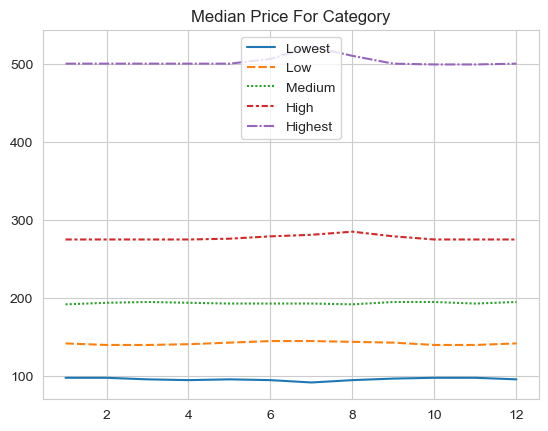

In [86]:
sns.lineplot(data=summary_df).set_title("Median Price For Category")
plt.show()

In [87]:
# categories = ['Lowest','Low','Medium','High','Highest']
# x = [month for month in summary_df['month'].unique()]
# y = {}
# for cat in categories:
#     category_price_series = summary_df[summary_df['price_category'] == cat]['median_price']
#     y[cat] = category_price_series
